# The $\chi^2_\Delta$ Test of Discrete Frequency Estimates

The $\chi^2_\Delta$ Test, pronounced *"Chi Square"*, is used to compare the parameter
estimates of two models of discrete frequency estimates from the same data, where the
models' degrees of freedom differ by $\Delta$, pronounce *"Delta"*. The degrees of freedom
of a model is simply the number of independent parameters that uniquely identify a single
model. In practice, this means we cannot use a parameterization where two different
combinations of parameters yields the same model.

> *For an example of a model that is **NOT** uniquely identifiable, consider an initial*
> *model where we estimate the parameter $r_\text{acc}$, the rate of traffic accidents per*
> *year. We then refine this parameterization to $r_\text{acc} = r_\text{hr} \times r_\text{drv}$,*
> *where $r_\text{hr}$ is the parameter for the rate of accidents per driver-hour, and*
> *$r_\text{drv}$ is the parameter for the rate of driver-hours per year. In this*
> *refinement there are many combinations of $r_\text{hr}$ and $r_\text{drv}$ that yield*
> *the same value of $r_\text{acc}$, and thus the refined parameterization is **NOT***
> *uniquely identifiable.*

To apply the $\chi^2_\Delta$ Test to estimates of discrete frequencies our two models must
satisfy the following criteria:
* The estimates of the models respective parameters must be based on the same observations
of independent identically distributed samples. You cannot compare models derived from
different observations.
* The model with the fewer degrees of freedom must be a restricted version of the model
with the larger degrees of freedom. That is there are additional relationships imposed on
the parameters in the model with the fewer degrees of freedom, such as independence between
variables in the observation.
* For both models must use Maximum Likelihood Estimation to fit the parameters.
* There are other regularity conditions around the theoretical finiteness of the means and
variances of the parameter estimates, and bounds on tails of the models. However, for models
of discrete frequency estimates these are generally satisfied.

If these conditions are satisfied then the $\chi^2_\Delta$ Test gives the conditional
asymptotic tail probability (one minus the cumulative probability) of observing as large of
a difference between the frequency estimates of the two models, in the limit of large sample
sizes, and assuming the model with the fewer degrees of freedom is true.

It is the role of the Data Analyst to contextualize the observed probability by providing an
interpretation within the context of the observed process. Improbably large differences
between the estimated frequencies are conventionally interpreted to indicate that the model
with fewer degrees of freedom is an inferior explanation, where as the model with the larger
number of degrees of freedom is a superior explanation.

The following concepts are related to the $\chi^2_\Delta$ Test:
* The [Likelihood Ratio Test](https://en.wikipedia.org/wiki/Likelihood-ratio_test) of the
[Maximum Likelihood Estimate](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).
* The [G-Test](https://en.wikipedia.org/wiki/G-test) of the G-Statistic.
* [Wilks' Theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem).
* [Pearson's Test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test).

The $\chi^2_\Delta$ Test is most commonly used to investigate the independence of two binary
categories in a $2 \times 2$ contingency table. In this case the difference of the degrees
of freedom is exactly $\Delta = 1$. In this form it is called Pearson's Test.

In Python the Pearson's Test is available in the `statistics` module of SciPy.
* Statistics [API Documentation](https://docs.scipy.org/doc/scipy/reference/stats.html).
* Statistics [User Guide](https://docs.scipy.org/doc/scipy/tutorial/stats.html).
* Pearson's Test [Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html).
* General Contingency Test [Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html).
* Cross Tabulation of [Actual Frequencies](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.crosstab.html)
* Estimation of Independent [Expected Frequencies](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.expected_freq.html).

In [1]:
# The usual suspects.
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as mp
import numpy as np
import ipywidgets as wg
import scipy.stats as st

## Data Load

We will demonstrate the $\chi^2_\Delta$ Test by testing whether survival on the Titanic
was independent of gender, or if there was a relationship between gender and survival. We
will use the most recent version of the Titanic Passenger Dataset, as of 2016, available
from the Vanderbilt Department of Biostatistics' [datasets page](https://hbiostat.org/data/).
* Source File `Data\titanic5.xlsx`
* Source Sheet `Titanic5_all`

We will use the Pandas
[read Excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html)
function. Note that the `Price` column is in units of
[Pounds, Shillings, Pence](https://en.wikipedia.org/wiki/%C2%A3sd). We will convert this
to Decimal Pounds using the factors:
* $\pounds 1 = 20 \text{s}$
* $\pounds 1 = 240 \text{d}$

Note the the Unicode for the British Pounds sign &pound; is hexidecimal `00A3`, or decimal
`0163`. 


In [2]:
# Load our data
embarked = pd.read_excel(
    "Data\\titanic5.xlsx",
    sheet_name = "Titanic5_all"
)

# Convert to decimal pounds
embarked["Decimal Price"] = (

    # Retrieve the pounds
    embarked["Price"].str.extract("(?<=\u00A3)([0-9]+)").astype(float).fillna(0.0) +

    # Retrieve the shillings
    embarked["Price"].str.extract("([0-9]+)(?=s)").astype(float).fillna(0.0) / 20.0 +

    # Retrieve the pence
    embarked["Price"].str.extract("([0-9]+)(?=d)").astype(float).fillna(0.0) / 240.0
)

## Pearson's Test for Independence
Pearson's Test for Independence in a $2 \times 2$ contingency table compares the actual
data to the expectation if the dimensions of the contingency table were independent. We
start by tabulating the frequencies by dividing the counts in the contingency tables by
the total observations.

We start by computing the marginal and joint frequencies or fractions:
$$
\begin{array}{rl}
    & \text{Marginal}\\\hline\\
    f_m & = \frac{\# \text{male} }{ \# \text{embarked}}\\\\
    f_d & = \frac{\# \text{died} }{ \# \text{embarked}}\\\\
    & \text{Joint}\\\hline\\
    f_{m,d} & = \frac{\# \text{male and died} }{ \# \text{embarked}}\\\\
    f_{m,l} & = \frac{\# \text{male and survied} }{ \# \text{embarked}}\\\\
    f_{w,d} & = \frac{\# \text{female and died} }{ \# \text{embarked}}
\end{array}
$$

The actual frequencies, or *"the data is what it is"* model, has three degrees of freedom,
the cross tabulated frequencies of survival by gender $f_{m,d}$, $f_{m,l}$, and $f_{w,d}$.
$$
\begin{array}{r|cc|c}
    & \text{Died} & \text{Lived}\\
    \hline
    \text{Men} & f_{m,d} & f_{m,l} & f_m\\
    \text{Women} & f_{w,d} & 1-f_{m,d}-f_{m,l}-f_{w,d} & 1-f_m\\
    \hline
    & f_d & 1-f_d
\end{array}
$$
The expected frequencies, or *"the survival is independent of gender"* model, has two
degrees of freedom, $f_m$, and $f_d$, the marginal frequencies of survival and gender
independently.
$$
\begin{array}{r|cc|c}
    & \text{Died} & \text{Lived}\\
    \hline
    \text{Men} & f_m \cdot f_d & f_m \cdot (1-f_d) & f_m\\
    \text{Women} & (1-f_m) \cdot f_d & (1-f_m) \cdot (1-f_d) & 1-f_m\\
    \hline
    & f_d & 1-f_d
\end{array}
$$
We determine the degrees of freedom of the test by counting up the number of possible
combinations of categorical variables in each model. Next for each model we subtract the
number of independent linear constraints. Finally we take the difference between the larger
and smaller values:
$$
\begin{array}{rl}
\Delta &= (2 \times 2 - 1) - ((2 - 1) + (2 - 1))\\
       &= 1
\end{array}
$$

In [3]:
# The "data is what it is" model
actual = st.contingency.crosstab(
    
    # Gender is the rows
    embarked["Sex"],
    
    # Survival is the columns
    embarked["Survived"]
)

# Row and column margins
margins = st.contingency.margins(actual.count)

# The "independence" model
expected = st.contingency.expected_freq(actual.count)

# Output
print("Rows")
print(actual.elements[0])
print(margins[0].reshape(1, -1))
print("\nColumns")
print(actual.elements[1])
print(margins[1].reshape(1, -1))
print("\nActual")
print(actual.count)
print("\nExpected")
print(expected)

Rows
['female' 'male']
[[ 489 1719]]

Columns
[0 1]
[[1496  712]]

Actual
[[ 130  359]
 [1366  353]]

Expected
[[ 331.31521739  157.68478261]
 [1164.68478261  554.31521739]]


### Marimekko Plots of Actual
We can illustrate the dependence of survival on gender with Marimekko plots of each model.

<BarContainer object of 2 artists>

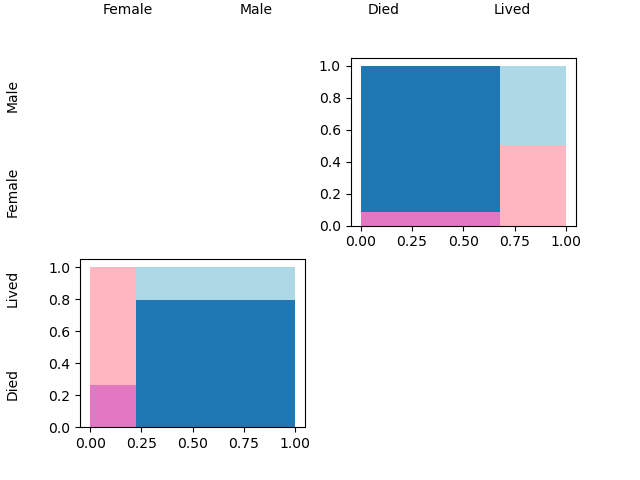

In [4]:
# Blank canvas for 2-by-2 Merimekko
actualfg, actualax = mp.subplots(2, 2)

# Label the figure
actualax[0, 0].axis("off")
actualax[1, 1].axis("off")
actualfg.text(0.20, 0.98, 'Female', ha='center', va='center')
actualfg.text(0.40, 0.98, 'Male', ha='center', va='center')
actualfg.text(0.60, 0.98, 'Died', ha='center', va='center')
actualfg.text(0.80, 0.98, 'Lived', ha='center', va='center')
actualfg.text(0.02, 0.80, 'Male', ha='center', va='center', rotation='vertical')
actualfg.text(0.02, 0.60, 'Female', ha='center', va='center', rotation='vertical')
actualfg.text(0.02, 0.40, 'Lived', ha='center', va='center', rotation='vertical')
actualfg.text(0.02, 0.20, 'Died', ha='center', va='center', rotation='vertical')

# Survival as a function of gender
actualax[1, 0].bar(
    np.cumsum(margins[0]) / np.sum(margins[0]),
    actual.count[:, 0] / margins[0].reshape(1, -1)[0],
    width = - margins[0].reshape(1, -1)[0] / np.sum(margins[0]),
    align = "edge",
    color = [ "tab:pink", "tab:blue" ]
)
actualax[1, 0].bar(
    np.cumsum(margins[0]) / np.sum(margins[0]),
    actual.count[:, 1] / margins[0].reshape(1, -1)[0],
    bottom = actual.count[:, 0] / margins[0].reshape(1, -1)[0],
    width = - margins[0].reshape(1, -1)[0] / np.sum(margins[0]),
    align = "edge",
    color = [ "lightpink", "lightblue" ]
)

# Gender as a function of survival
actualax[0, 1].bar(
    np.cumsum(margins[1]) / np.sum(margins[1]),
    actual.count[0, :] / margins[1].reshape(1, -1)[0],
    width = - margins[1].reshape(1, -1)[0] / np.sum(margins[1]),
    align = "edge",
    color = [ "tab:pink", "lightpink" ]
)
actualax[0, 1].bar(
    np.cumsum(margins[1]) / np.sum(margins[1]),
    actual.count[1, :] / margins[1].reshape(1, -1)[0],
    bottom = actual.count[0, :] / margins[1].reshape(1, -1)[0],
    width = - margins[1].reshape(1, -1)[0] / np.sum(margins[1]),
    align = "edge",
    color = [ "tab:blue", "lightblue" ]
)

### Marimekko Plots of Expected
We can illustrate the dependence of survival on gender with Marimekko plots of each model.

<BarContainer object of 2 artists>

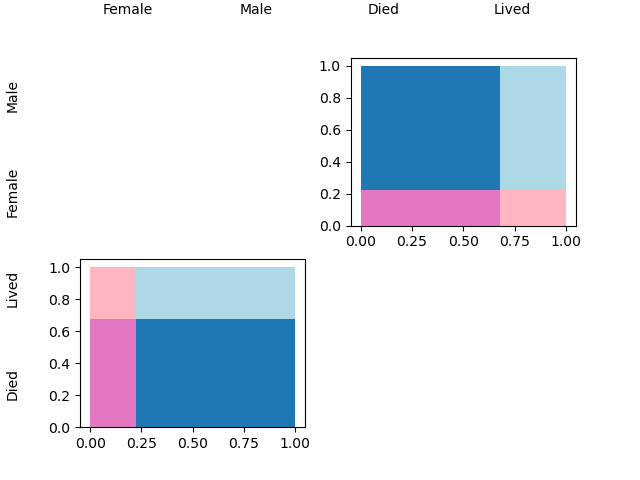

In [5]:
# Blank canvas for 2-by-2 Merimekko
expectedfg, expectedax = mp.subplots(2, 2)

# Label the figure
expectedax[0, 0].axis("off")
expectedax[1, 1].axis("off")
expectedfg.text(0.20, 0.98, 'Female', ha='center', va='center')
expectedfg.text(0.40, 0.98, 'Male', ha='center', va='center')
expectedfg.text(0.60, 0.98, 'Died', ha='center', va='center')
expectedfg.text(0.80, 0.98, 'Lived', ha='center', va='center')
expectedfg.text(0.02, 0.80, 'Male', ha='center', va='center', rotation='vertical')
expectedfg.text(0.02, 0.60, 'Female', ha='center', va='center', rotation='vertical')
expectedfg.text(0.02, 0.40, 'Lived', ha='center', va='center', rotation='vertical')
expectedfg.text(0.02, 0.20, 'Died', ha='center', va='center', rotation='vertical')

# Survival as a function of gender
expectedax[1, 0].bar(
    np.cumsum(margins[0]) / np.sum(margins[0]),
    expected[:, 0] / margins[0].reshape(1, -1)[0],
    width = - margins[0].reshape(1, -1)[0] / np.sum(margins[0]),
    align = "edge",
    color = [ "tab:pink", "tab:blue" ]
)
expectedax[1, 0].bar(
    np.cumsum(margins[0]) / np.sum(margins[0]),
    expected[:, 1] / margins[0].reshape(1, -1)[0],
    bottom = expected[:, 0] / margins[0].reshape(1, -1)[0],
    width = - margins[0].reshape(1, -1)[0] / np.sum(margins[0]),
    align = "edge",
    color = [ "lightpink", "lightblue" ]
)

# Gender as a function of survival
expectedax[0, 1].bar(
    np.cumsum(margins[1]) / np.sum(margins[1]),
    expected[0, :] / margins[1].reshape(1, -1)[0],
    width = - margins[1].reshape(1, -1)[0] / np.sum(margins[1]),
    align = "edge",
    color = [ "tab:pink", "lightpink" ]
)
expectedax[0, 1].bar(
    np.cumsum(margins[1]) / np.sum(margins[1]),
    expected[1, :] / margins[1].reshape(1, -1)[0],
    bottom = expected[0, :] / margins[1].reshape(1, -1)[0],
    width = - margins[1].reshape(1, -1)[0] / np.sum(margins[1]),
    align = "edge",
    color = [ "tab:blue", "lightblue" ]
)

### Significance Test
In this context a small P-Value of the Pearson's Test indicates that our observation of 
large difference between the observation of the dependence of survival on gender and
survival being independent of gender is unlikely to be due to random chance alone.


In [6]:
# The Pearson's Text. Counts are large enough that we do not need the correction.
test = st.chi2_contingency(
    actual.count,
    correction = False
)

# Output
print("Test")
print(f"Statistic: {test.statistic}")
print(f"P-Value: {test.pvalue}")
print(f"Degrees of Freedom: {test.dof}")

Test
Statistic: 487.2525189655863
P-Value: 5.6446379262686844e-108
Degrees of Freedom: 1


### Interpretation
The P-Value can be interpreted as meaning **IF** survival is independent of gender **THEN**
there is a $5.6 \times 10^{-106} \%$ chance of observing the actual data.

## Survival by Port of Origin
In this example we observe the dependence of survival on the port of origin.

In [7]:
# The "data is what it is" model
originactual = st.contingency.crosstab(
    
    # Port is the rows
    embarked["Joined"],
    
    # Survival is the columns
    embarked["Survived"]
)

# Row and column margins
originmargins = st.contingency.margins(originactual.count)

# The "independence" model
originexpected = st.contingency.expected_freq(originactual.count)

# Output
print("Ports")
print(originactual.elements[0])
print(originmargins[0].reshape(1, -1))
print("\nSurvival")
print(originactual.elements[1])
print(originmargins[1].reshape(1, -1))
print("\nActual")
print(originactual.count)
print("\nExpected")
print(originexpected)

Ports
['Belfast' 'Cherbourg' 'Queenstown' 'Southampton']
[[ 199  272  123 1614]]

Survival
[0 1]
[[1496  712]]

Actual
[[ 155   44]
 [ 118  154]
 [  79   44]
 [1144  470]]

Expected
[[ 134.82971014   64.17028986]
 [ 184.28985507   87.71014493]
 [  83.33695652   39.66304348]
 [1093.54347826  520.45652174]]


### Merimekko of Actual Survival by Origin

<BarContainer object of 2 artists>

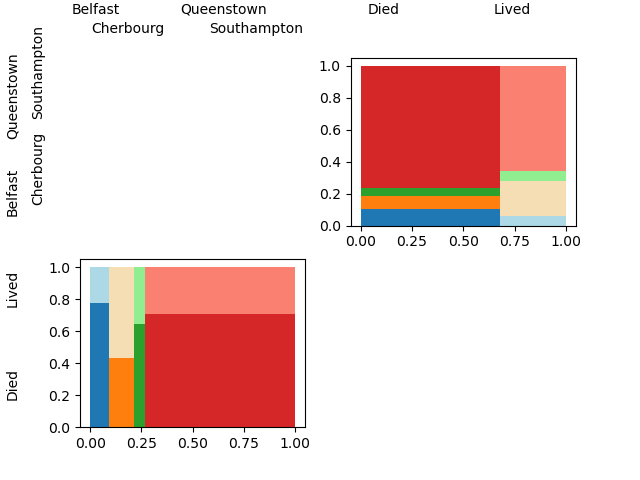

In [8]:
# Blank canvas for 2-by-2 Merimekko
originactualfg, originactualax = mp.subplots(2, 2)

# Label the figure
originactualax[0, 0].axis("off")
originactualax[1, 1].axis("off")
originactualfg.text(0.15, 0.98, 'Belfast', ha='center', va='center')
originactualfg.text(0.20, 0.94, 'Cherbourg', ha='center', va='center')
originactualfg.text(0.35, 0.98, 'Queenstown', ha='center', va='center')
originactualfg.text(0.40, 0.94, 'Southampton', ha='center', va='center')
originactualfg.text(0.60, 0.98, 'Died', ha='center', va='center')
originactualfg.text(0.80, 0.98, 'Lived', ha='center', va='center')
originactualfg.text(0.02, 0.60, 'Belfast', ha='center', va='center', rotation='vertical')
originactualfg.text(0.06, 0.65, 'Cherbourg', ha='center', va='center', rotation='vertical')
originactualfg.text(0.02, 0.80, 'Queenstown', ha='center', va='center', rotation='vertical')
originactualfg.text(0.06, 0.85, 'Southampton', ha='center', va='center', rotation='vertical')
originactualfg.text(0.02, 0.40, 'Lived', ha='center', va='center', rotation='vertical')
originactualfg.text(0.02, 0.20, 'Died', ha='center', va='center', rotation='vertical')

# Survival as a function of origin
originactualax[1, 0].bar(
    np.cumsum(originmargins[0]) / np.sum(originmargins[0]),
    originactual.count[:, 0] / originmargins[0].reshape(1, -1)[0],
    width = - originmargins[0].reshape(1, -1)[0] / np.sum(originmargins[0]),
    align = "edge",
    color = [ "tab:blue", "tab:orange", "tab:green", "tab:red" ]
)
originactualax[1, 0].bar(
    np.cumsum(originmargins[0]) / np.sum(originmargins[0]),
    originactual.count[:, 1] / originmargins[0].reshape(1, -1)[0],
    bottom = originactual.count[:, 0] / originmargins[0].reshape(1, -1)[0],
    width = - originmargins[0].reshape(1, -1)[0] / np.sum(margins[0]),
    align = "edge",
    color = [ "lightblue", "wheat", "lightgreen", "salmon" ]
)

# Origin as a function of survival
originactualax[0, 1].bar(
    np.cumsum(originmargins[1]) / np.sum(originmargins[1]),
    originactual.count[0, :] / originmargins[1].reshape(1, -1)[0],
    width = - originmargins[1].reshape(1, -1)[0] / np.sum(originmargins[1]),
    align = "edge",
    color = [ "tab:blue", "lightblue" ]
)
originactualax[0, 1].bar(
    np.cumsum(originmargins[1]) / np.sum(originmargins[1]),
    originactual.count[1, :] / originmargins[1].reshape(1, -1)[0],
    bottom = originactual.count[0, :] / originmargins[1].reshape(1, -1)[0],
    width = - originmargins[1].reshape(1, -1)[0] / np.sum(originmargins[1]),
    align = "edge",
    color = [ "tab:orange", "wheat" ]
)
originactualax[0, 1].bar(
    np.cumsum(originmargins[1]) / np.sum(originmargins[1]),
    originactual.count[2, :] / originmargins[1].reshape(1, -1)[0],
    bottom = (originactual.count[0, :] + originactual.count[1, :]) / originmargins[1].reshape(1, -1)[0],
    width = - originmargins[1].reshape(1, -1)[0] / np.sum(originmargins[1]),
    align = "edge",
    color = [ "tab:green", "lightgreen" ]
)
originactualax[0, 1].bar(
    np.cumsum(originmargins[1]) / np.sum(originmargins[1]),
    originactual.count[3, :] / originmargins[1].reshape(1, -1)[0],
    bottom = (originactual.count[0, :] + originactual.count[1, :] + originactual.count[2, :]) / originmargins[1].reshape(1, -1)[0],
    width = - originmargins[1].reshape(1, -1)[0] / np.sum(originmargins[1]),
    align = "edge",
    color = [ "tab:red", "salmon" ]
)

### Merimekko of Expected Survival by Origin

<BarContainer object of 2 artists>

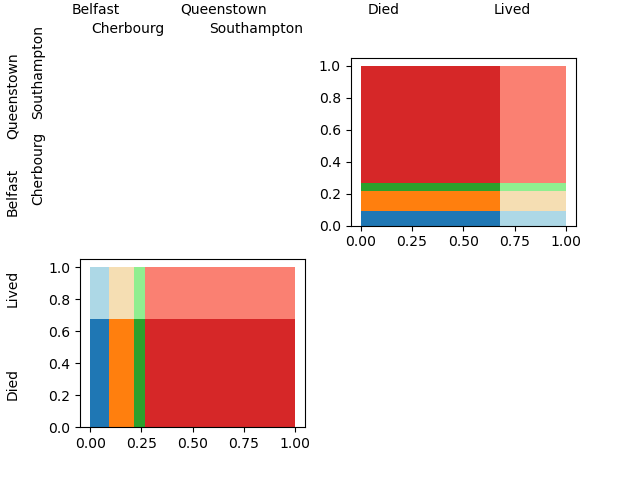

In [9]:
# Blank canvas for 2-by-2 Merimekko
originexpectedfg, originexpectedax = mp.subplots(2, 2)

# Label the figure
originexpectedax[0, 0].axis("off")
originexpectedax[1, 1].axis("off")
originexpectedfg.text(0.15, 0.98, 'Belfast', ha='center', va='center')
originexpectedfg.text(0.20, 0.94, 'Cherbourg', ha='center', va='center')
originexpectedfg.text(0.35, 0.98, 'Queenstown', ha='center', va='center')
originexpectedfg.text(0.40, 0.94, 'Southampton', ha='center', va='center')
originexpectedfg.text(0.60, 0.98, 'Died', ha='center', va='center')
originexpectedfg.text(0.80, 0.98, 'Lived', ha='center', va='center')
originexpectedfg.text(0.02, 0.60, 'Belfast', ha='center', va='center', rotation='vertical')
originexpectedfg.text(0.06, 0.65, 'Cherbourg', ha='center', va='center', rotation='vertical')
originexpectedfg.text(0.02, 0.80, 'Queenstown', ha='center', va='center', rotation='vertical')
originexpectedfg.text(0.06, 0.85, 'Southampton', ha='center', va='center', rotation='vertical')
originexpectedfg.text(0.02, 0.40, 'Lived', ha='center', va='center', rotation='vertical')
originexpectedfg.text(0.02, 0.20, 'Died', ha='center', va='center', rotation='vertical')

# Survival as a function of origin
originexpectedax[1, 0].bar(
    np.cumsum(originmargins[0]) / np.sum(originmargins[0]),
    originexpected[:, 0] / originmargins[0].reshape(1, -1)[0],
    width = - originmargins[0].reshape(1, -1)[0] / np.sum(originmargins[0]),
    align = "edge",
    color = [ "tab:blue", "tab:orange", "tab:green", "tab:red" ]
)
originexpectedax[1, 0].bar(
    np.cumsum(originmargins[0]) / np.sum(originmargins[0]),
    originexpected[:, 1] / originmargins[0].reshape(1, -1)[0],
    bottom = originexpected[:, 0] / originmargins[0].reshape(1, -1)[0],
    width = - originmargins[0].reshape(1, -1)[0] / np.sum(margins[0]),
    align = "edge",
    color = [ "lightblue", "wheat", "lightgreen", "salmon" ]
)

# Origin as a function of survival
originexpectedax[0, 1].bar(
    np.cumsum(originmargins[1]) / np.sum(originmargins[1]),
    originexpected[0, :] / originmargins[1].reshape(1, -1)[0],
    width = - originmargins[1].reshape(1, -1)[0] / np.sum(originmargins[1]),
    align = "edge",
    color = [ "tab:blue", "lightblue" ]
)
originexpectedax[0, 1].bar(
    np.cumsum(originmargins[1]) / np.sum(originmargins[1]),
    originexpected[1, :] / originmargins[1].reshape(1, -1)[0],
    bottom = originexpected[0, :] / originmargins[1].reshape(1, -1)[0],
    width = - originmargins[1].reshape(1, -1)[0] / np.sum(originmargins[1]),
    align = "edge",
    color = [ "tab:orange", "wheat" ]
)
originexpectedax[0, 1].bar(
    np.cumsum(originmargins[1]) / np.sum(originmargins[1]),
    originexpected[2, :] / originmargins[1].reshape(1, -1)[0],
    bottom = (originexpected[0, :] + originexpected[1, :]) / originmargins[1].reshape(1, -1)[0],
    width = - originmargins[1].reshape(1, -1)[0] / np.sum(originmargins[1]),
    align = "edge",
    color = [ "tab:green", "lightgreen" ]
)
originexpectedax[0, 1].bar(
    np.cumsum(originmargins[1]) / np.sum(originmargins[1]),
    originexpected[3, :] / originmargins[1].reshape(1, -1)[0],
    bottom = (originexpected[0, :] + originexpected[1, :] + originexpected[2, :]) / originmargins[1].reshape(1, -1)[0],
    width = - originmargins[1].reshape(1, -1)[0] / np.sum(originmargins[1]),
    align = "edge",
    color = [ "tab:red", "salmon" ]
)

### Significance Test
Our observation of a dependence of survival on the port of origin is statistically
significant. The degrees of freedom is given by:
$$
\begin{array}{rl}
\Delta &= (2 \times 4 - 1) - ((2 - 1) + (4 - 1))\\
       &= 3
\end{array}
$$

In [10]:
# The Pearson's Text. Counts are large enough that we do not need the correction.
origintest = st.chi2_contingency(
    originactual.count,
    correction = False
)

# Output
print("Test")
print(f"Statistic: {origintest.statistic}")
print(f"P-Value: {origintest.pvalue}")
print(f"Degrees of Freedom: {origintest.dof}")

Test
Statistic: 91.22256122317756
P-Value: 1.196598937786613e-19
Degrees of Freedom: 3


### Interpretation
The P-Value can be interpreted as meaning **IF** survival is independent of the port of
origin **THEN** there is an $1.2 \times 10^{-17}\%$ chance of observing the actual data.

## Statistical Testing Hierarchy
There are many possible explanations for the relationships we have seen so far. For
instance, there maybe a relationship between gender and port of origin that accounts for
the dependence of survival on the port of origin. To proceed we must first take a step
back.

Recall from our lecture on Biases, Fallacies, and Paradoxes that there are many ways we
can misinterpret and misrepresent our analysis. In fact, the examples we have covered so
far are vulnerable to the Multiple Comparisons Fallacy. By comparing variables pairwise we
risk identifying spurious relationships, those due to chance alone, as being meaningful. How
do we decrease the risk of the Multiple Comparisons Fallacy?

We conduct our tests through a hierarchy of comparisons. We start by comparing the simplest
model to the most complex. In our case we would compare a model that assumes all the 
variables are independent to the "data is what it is", where all the variables depend on
each other. This test is called the Omnibus Test.

In the Titanic dataset we will consider the four variables:
1. Gender
2. Port of Origin
3. Class or Department
4. Survival

The Omnibus test compares the completely independent model.
$$
\operatorname{\mathbb{P}}[\text{Srv}, \text{Gdr}, \text{Cls}, \text{Prt}] =
\operatorname{\mathbb{P}}[\text{Srv}] \cdot
\operatorname{\mathbb{P}}[\text{Gdr}] \cdot
\operatorname{\mathbb{P}}[\text{Cls}] \cdot
\operatorname{\mathbb{P}}[\text{Prt}]
$$
To the "data is what is model", where we cannot resolve any independence.
$$
\operatorname{\mathbb{P}}[\text{Srv}, \text{Gdr}, \text{Cls}, \text{Prt}]
$$
If the Omnibus Test is significant then we can work inwards, recursively eliminating models
through judicious comparisons. In the Titanic example, our next step is to test if Survival
is independent of Port of Origin given the gender and class.


In [11]:
# The "data is what it is" model
omnibusactual = st.contingency.crosstab(

    # Gender is first dimension
    embarked["Sex"],
    
    # Port is the second dimension
    embarked["Joined"],

    # Passenger class or crew department is the third dimension
    embarked["Class"].astype(str, copy = False),
    
    # Survival is the final dimension
    embarked["Survived"]
)

# Row and column margins
omnibusmargins = st.contingency.margins(omnibusactual.count)

# The "independence" model
omnibusexpected = st.contingency.expected_freq(omnibusactual.count)

# Output
print("Genders")
print(omnibusactual.elements[0])
print(omnibusmargins[0].reshape(1, -1))
print("\nPorts")
print(omnibusactual.elements[1])
print(omnibusmargins[1].reshape(1, -1))
print("\nClasses")
print(omnibusactual.elements[2])
print(omnibusmargins[2].reshape(1, -1))
print("\nSurvival")
print(omnibusactual.elements[3])
print(omnibusmargins[3].reshape(1, -1))
print("\nActual")
print(omnibusactual.count)
print("\nExpected")
print(omnibusexpected)

Genders
['female' 'male']
[[ 489 1719]]

Ports
['Belfast' 'Cherbourg' 'Queenstown' 'Southampton']
[[ 199  272  123 1614]]

Classes
['1' '2' '3' 'B' 'D' 'E' 'R' 'V']
[[324 276 709   8  66 325  69 431]]

Survival
[0 1]
[[1496  712]]

Actual
[[[[  0   0]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]]

  [[  2  75]
   [  0  11]
   [  9  22]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]]

  [[  0   2]
   [  0   2]
   [ 23  33]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]]

  [[  3  62]
   [ 12  81]
   [ 78  51]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   2]
   [  3  18]]]


 [[[  4   0]
   [  6   0]
   [  0   0]
   [  0   0]
   [  7  16]
   [ 41   3]
   [  0   0]
   [ 97  25]]

  [[ 40  27]
   [ 11   4]
   [ 56  15]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]]

  [[  1   0]
   [  5   0]
   [ 50   7]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]
   [  0   0]]

  [[ 73  35]
   [

### Omnibus Statistical Test
The Omnibus Statistical test is significant, as was expected. We can now proceed to see if
survival is conditionally independent of port of origin, after we have accounted for gender
and class. Our degrees of freedom calculation:
$$
\begin{array}{rl}
\Delta &= (2 \times 2 \times 8 \times 4 - 1) -
((2 - 1) + (2 - 1) + (8 - 1) + (4 - 1))\\
       &= 115
\end{array}
$$

In [12]:
# The Pearson's Text
omnibustest = st.chi2_contingency(
    omnibusactual.count,
    correction = False
)

# Output
print("Test")
print(f"Statistic: {omnibustest.statistic}")
print(f"P-Value: {omnibustest.pvalue}")
print(f"Degrees of Freedom: {omnibustest.dof}")

Test
Statistic: 4079.087953985658
P-Value: 0.0
Degrees of Freedom: 115


### Interpretation
The P-Value can be interpreted as meaning **IF** all the variables were independent of each
other **THEN** there is an 0% chance of observing the actual data.

### Test for Conditional Independence
To construct a test for the conditional independence of survival from the port of origin we
first have to build a model for Survival, as mediated by gender and class or department.
$$
\operatorname{\mathbb{P}}[\text{Srv}, \text{Gdr}, \text{Cls}, \text{Prt}] =
\operatorname{\mathbb{P}}[\text{Srv} \| \text{Gdr}, \text{Cls}] \cdot
\operatorname{\mathbb{P}}[\text{Gdr}, \text{Cls} \| \text{Prt}] \cdot
\operatorname{\mathbb{P}}[\text{Prt}]
$$
The furthest right probability is simply the marginal distribution of embarked over the
cities of origin. This does nothing more than simple measure the relative volume of embarked
for each port.

The middle probability is the conditional distribution of genders and classes or departments on
the port of origin. This measures how the genders and classes or departments varied by port.
For example, most of the crew embarked from Belfast, most steerage embarked from
Southampton, and Cherbourg embarked mostly first class passengers and their attendants.

The probability to the immediate right of the equality operator is the distribution of
survival conditioned on gender and class or department. This measures the risk faced by
each combination of gender and class or department. If we observe that survival is
conditionally independent of the port of origin than we can further investigate to see
if the survival risks were compounding in gender and class or department.

Multiplying both sides of the model by the actual number of embarked tells us how to 
compute are model of expected survival from the actual marginal counts.
$$
\operatorname{\mathbb{E}}\#[\text{Srv}, \text{Gdr}, \text{Cls}, \text{Prt}] =
\frac{\#[\text{Srv}, \text{Gdr}, \text{Cls}]}
{\#[\text{Gdr}, \text{Cls}]} \cdot
\#[\text{Gdr}, \text{Cls}, \text{Prt}]
$$
Each term on the right hand side is simply the counts from the respective contingency table.

In [13]:
# Survival, Gender, Class-Department contingency
survivalactual = st.contingency.crosstab(

    # Survival is first dimension
    embarked["Survived"],
    
    # Gender is the second dimension
    embarked["Sex"],
    
    # Passenger class or crew department is the final dimension
    embarked["Class"].astype(str, copy = False)
)

# Gender, Class-Department contingency
genderactual = st.contingency.crosstab(

    # Gender is first dimension
    embarked["Sex"],

    # Passenger class or crew department is the final dimension
    embarked["Class"].astype(str, copy = False)
)

# Gender, Class-Department, Port contingency
portactual = st.contingency.crosstab(

    # Gender is first dimension
    embarked["Sex"],

    # Passenger class or crew department is the second dimension
    embarked["Class"].astype(str, copy = False),
    
    # Port is the final dimension
    embarked["Joined"]
)

# Contingency tables
print("Survival, Gender, Class or Department")
print(survivalactual.count)
print("\nGender, Class or Department")
print(genderactual.count)
print("\nGender, Class or Department, Port")
print(portactual.count)

Survival, Gender, Class or Department
[[[  5  12 110   0   0   0   0   3]
  [118 146 418   8  23 253  66 334]]

 [[139  94 106   0   0   0   2  18]
  [ 62  24  75   0  43  72   1  76]]]

Gender, Class or Department
[[144 106 216   0   0   0   2  21]
 [180 170 493   8  66 325  67 410]]

Gender, Class or Department, Port
[[[  0  77   2  65]
  [  0  11   2  93]
  [  0  31  56 129]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   2]
  [  0   0   0  21]]

 [[  4  67   1 108]
  [  6  15   5 144]
  [  0  71  57 365]
  [  0   0   0   8]
  [ 23   0   0  43]
  [ 44   0   0 281]
  [  0   0   0  67]
  [122   0   0 288]]]


### Actual Contingency
We re-run the same cross tabulation of the actual contingency table as for the Omnibus test,
except we change the order of the variables to match the order of the model:
1. Survival
2. Gender
3. Class or Department
4. Port of Origin

In [14]:
conditionalactual = st.contingency.crosstab(

    # Survival is first dimension
    embarked["Survived"],

    # Gender is second dimension
    embarked["Sex"],

    # Passenger class or crew department is the third dimension
    embarked["Class"].astype(str, copy = False),
    
    # Port is the final dimension
    embarked["Joined"]
)
print("Actual Survival, Gender, Class or Department, Port")
print(conditionalactual.count)

Actual Survival, Gender, Class or Department, Port
[[[[  0   2   0   3]
   [  0   0   0  12]
   [  0   9  23  78]
   [  0   0   0   0]
   [  0   0   0   0]
   [  0   0   0   0]
   [  0   0   0   0]
   [  0   0   0   3]]

  [[  4  40   1  73]
   [  6  11   5 124]
   [  0  56  50 312]
   [  0   0   0   8]
   [  7   0   0  16]
   [ 41   0   0 212]
   [  0   0   0  66]
   [ 97   0   0 237]]]


 [[[  0  75   2  62]
   [  0  11   2  81]
   [  0  22  33  51]
   [  0   0   0   0]
   [  0   0   0   0]
   [  0   0   0   0]
   [  0   0   0   2]
   [  0   0   0  18]]

  [[  0  27   0  35]
   [  0   4   0  20]
   [  0  15   7  53]
   [  0   0   0   0]
   [ 16   0   0  27]
   [  3   0   0  69]
   [  0   0   0   1]
   [ 25   0   0  51]]]]


### Index Munging
To calculate the expected conditional survival we need to undertake a bit of index munging
using NumPy's [Einstein Summation](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)
to compute the element wise multiplications and divisions.
$$
\operatorname{\mathbb{E}}\operatorname{Num}_{\text{Srv}, \text{Gdr}, \text{Cls}, \text{Prt}} =
\operatorname{Num}_{\text{Srv}, \text{Gdr}, \text{Cls}} \cdot
\frac{1}{\operatorname{Num}_{\text{Gdr}, \text{Cls}}} \cdot
\operatorname{Num}_{\text{Gdr}, \text{Cls}, \text{Prt}}
$$

In [15]:
conditionalexpected = np.einsum(

    # How to combine the values in the variable dimensions
    "sgc,gc,gcp->sgcp",

    # Multiply by the joint count of survival, gender, class
    survivalactual.count,

    # Divide by the joint count of gender and class
    1 / np.maximum(1, genderactual.count),

    # Multiply by the joint count of gender, class, and port
    portactual.count
)
print("Expected Survival, Gender, Class or Department, Port")
print(conditionalexpected)

Expected Survival, Gender, Class or Department, Port
[[[[0.00000000e+00 2.67361111e+00 6.94444444e-02 2.25694444e+00]
   [0.00000000e+00 1.24528302e+00 2.26415094e-01 1.05283019e+01]
   [0.00000000e+00 1.57870370e+01 2.85185185e+01 6.56944444e+01]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00]]

  [[2.62222222e+00 4.39222222e+01 6.55555556e-01 7.08000000e+01]
   [5.15294118e+00 1.28823529e+01 4.29411765e+00 1.23670588e+02]
   [0.00000000e+00 6.01987830e+01 4.83286004e+01 3.09472617e+02]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.00000000e+00]
   [8.01515152e+00 0.00000000e+00 0.00000000e+00 1.49848485e+01]
   [3.42523077e+01 0.00000000e+00 0.00000000e+00 2.18747692e+02]
   [0.00000000e+00 0.00000000e+00 0

### Quality Control
We can quickly test to make sure our model is minimal plausible by seeing if the totals of
expected and actual are the same

In [16]:
print(f"Actual: {np.sum(conditionalactual.count)}")
print(f"Expected: {np.sum(conditionalexpected)}")

Actual: 2208
Expected: 2208.0


### Test of Conditional Independence
Since we have compiled our own expected model we will use the $\chi^2_\Delta$ 
[distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html)
from the SciPy library. This is necessary for two reasons: first, the prebuilt tests only
compare complete independence to complete dependence; second, the prebuilt tests require all
the contingency cells of both actual and expected to be greater than zero. However, since we
are calculating an expected from the conditional and marginal distributions of the actual
data we know that our expected probabilities will only every be zero when the actual
probability is zero.

We will use the G-Statistic, where our cells are over every combination of categorical
variable values in our contingency table:
$$
g = 2 \cdot \sum_{\text{cell } \in \text{ cells}}
\#\text{act}_{\text{cell}} \cdot \left(
       \log(\#\text{act}_{\text{cell}}) -
       \log(\#\text{exp}_{\text{cell}})
\right)
$$
Our degrees of freedom will be:
$$
\begin{array}{rl}
\Delta &= (2 \times 2 \times 8 \times 4 - 1) - (
       (2 \times 2 \times 8 - 1) +
       (2 \times 8 \times 4 - 2 \times 8)
)\\
       &= 48
\end{array}
$$
Our significance test is then given by the tail probability of the $\chi^2_\Delta$
distribution:
$$
\alpha = 1 - \operatorname{\chi^2_{48}}[G < g]
$$
Note we will use a little trick of lower truncating the actual and expected counts in the
logarithm at one. This will cause the logarithm to return zero, which is fine because the
expected counts will only be zero if the actual counts are zero.

In [17]:
# Summing over all the cells in the table
gstatistic = 2 * np.sum(

    # The actual frequencies
    conditionalactual.count * (

        # Log of actual frequencies
        np.log(np.maximum(1, conditionalactual.count)) -

        # Log of expected frequencies
        np.log(np.maximum(1, conditionalexpected))
    )
)

# Tail probability
gtest = 1 - st.chi2(48).cdf(gstatistic)

# Output
print("Test")
print(f"G Statistic: {gstatistic}")
print(f"P-Value: {gtest}")

Test
G Statistic: 38.112156276631765
P-Value: 0.8458653184565603


### Interpretation
Once we have accounted for the distribution of gender and class or department across ports
of origin we find that survival is conditionally independent of the port of origin. This
means for all future analysis, provided we include gender and class or department, we can
exclude port of origin from the analysis.

The P-Value can be interpreted as meaning **IF** survival is conditionally independent of
the port of origin **THEN** there is an 85% chance of observing the actual data.

### Compound Hazard Model
With port of origin accounted for, we can now proceed to investigate whether the risks due
to gender and class interacted individually or more simply compounded. For this model
every the hazard of dying requires both the chances of gender and class being against
the person:
$$
\operatorname{\mathbb{P}}[\text{Died}, \text{Gdr}, \text{Cls}] =
\operatorname{\mathbb{P}}[\text{Died} \| \text{Gdr}] \cdot
\operatorname{\mathbb{P}}[\text{Died} \| \text{Cls}] \cdot
\operatorname{\mathbb{P}}[\text{Gdr}, \text{Cls}]
$$
And conversely the probability of dying is given by one minus the conditional probabilities:
$$
\operatorname{\mathbb{P}}[\text{Lived}, \text{Gdr}, \text{Cls}] = \left(
    1 - \operatorname{\mathbb{P}}[\text{Died} \| \text{Gdr}] \cdot
    \operatorname{\mathbb{P}}[\text{Died} \| \text{Cls}]
\right) \cdot
\operatorname{\mathbb{P}}[\text{Gdr}, \text{Cls}]
$$
The degrees of freedom is then:
$$
\begin{array}{rl}
\Delta &= (2 \times 2 \times 8 - 1) - (2 + 8 + (2 \times 8 - 1))\\
       &= 6
\end{array}
$$
We can interpret this model as saying that we have to take the socio-demographic
distribution of gender and class or department for what it is, and that given a gender and
class or department the risks multiply.
$$
\operatorname{\mathbb{E}}\operatorname{Num}_{\text{Die}, \text{Gdr}, \text{Cls}} =
\frac{\operatorname{Num}_{\text{Die}, \text{Gdr}}}{\operatorname{Num}_{\text{Gdr}}} \cdot
\frac{\operatorname{Num}_{\text{Die}, \text{Cls}}}{\operatorname{Num}_{\text{Cls}}} \cdot
\operatorname{Num}_{\text{Gdr}, \text{Cls}}
$$
Likewise
$$
\operatorname{\mathbb{E}}\operatorname{Num}_{\text{Lvd}, \text{Gdr}, \text{Cls}} = \left(
    1 - 
    \frac{\operatorname{Num}_{\text{Die}, \text{Gdr}}}{\operatorname{Num}_{\text{Gdr}}} \cdot
    \frac{\operatorname{Num}_{\text{Die}, \text{Cls}}}{\operatorname{Num}_{\text{Cls}}}
\right) \cdot
\operatorname{Num}_{\text{Gdr}, \text{Cls}}
$$

In [37]:
# Allocate space for the expected model without ports
compoundexpected = np.zeros((2, 2, 8))

# Survival and gender
compoundgenderactual = st.contingency.crosstab(

    # Survival is first dimension
    embarked["Survived"],

    # Gender is final dimension
    embarked["Sex"]
)

# Survival and class
compoundclassactual = st.contingency.crosstab(

    # Survival is first dimension
    embarked["Survived"],

    # Passenger class or crew department is the final dimension
    embarked["Class"].astype(str, copy = False)
)

# Demographics
compounddemographicsactual = st.contingency.crosstab(

    # Gender is first dimension
    embarked["Sex"],

    # Passenger class or crew department is the final dimension
    embarked["Class"].astype(str, copy = False)
)

# Actual joint counts
compoundactual = st.contingency.crosstab(

    # Survival is first dimension
    embarked["Survived"],

    # Gender is second dimension
    embarked["Sex"],

    # Passenger class or crew department is the final dimension
    embarked["Class"].astype(str, copy = False)
)

# Row and column margins
compoundmargins = st.contingency.margins(compoundactual.count)


# Build the model
compoundconditonal = np.einsum(
    "g,c->gc",
    compoundgenderactual.count[0, :] / compoundmargins[1].reshape(1, -1)[0],
    compoundclassactual.count[0, :] / compoundmargins[2].reshape(1, -1)[0]
)

# Expected mortality by gender and class
compoundexpected[0, :, :] = np.einsum(
    "gc,gc->gc",
    compoundconditonal,
    compounddemographicsactual.count
)

# Expected survival by gender and class
compoundexpected[1, :, :] = np.einsum(
    "gc,gc->gc",
    1 - compoundconditonal,
    compounddemographicsactual.count
)

# Check
print("Actual Survival, Gender, Class or Department")
print(compoundactual.count)
print("\nExpected Survival, Gender, Class or Department")
print(compoundexpected)
print("\nCheck Sum")
print(f"Actual: {np.sum(compoundactual.count)}")
print(f"Expected: {np.sum(compoundexpected)}")

Actual Survival, Gender, Class or Department
[[[  5  12 110   0   0   0   0   3]
  [118 146 418   8  23 253  66 334]]

 [[139  94 106   0   0   0   2  18]
  [ 62  24  75   0  43  72   1  76]]]

Expected Survival, Gender, Class or Department
[[[ 14.53306067  16.13200557  42.76376474   0.           0.
     0.           0.50858007   4.36522284]
  [ 54.30095016  77.33422701 291.74903571   6.35718441  18.27690518
   201.04595695  50.92657511 254.74830913]]

 [[129.46693933  89.86799443 173.23623526   0.           0.
     0.           1.49141993  16.63477716]
  [125.69904984  92.66577299 201.25096429   1.64281559  47.72309482
   123.95404305  16.07342489 155.25169087]]]

Check Sum
Actual: 2208
Expected: 2208.0


In [23]:
print("Gender and Class Contingency Table")
print(100 * compounddemographicsactual.count / 2208)

Gender and Class Contingency Table
[[ 6.52173913  4.80072464  9.7826087   0.          0.          0.
   0.09057971  0.95108696]
 [ 8.15217391  7.69927536 22.32789855  0.36231884  2.98913043 14.7192029
   3.03442029 18.56884058]]


In [36]:
print("Survival Gender Contingency Table")
print(compoundgenderactual.count)
print("\nProbabilities")
print(compoundgenderactual.count[0, :] / compoundmargins[1].reshape(1, -1)[0])
print(f"\nFemale Mortality: {130 / (130 + 359)}")
print(f"\nFemale Mortality: {1366 / (353 + 1366)}")
print("\n Mortality")
print(compoundgenderactual.count[0, :])
print("\nMargins")
print(compoundmargins[1].reshape(1, -1)[0])

Survival Gender Contingency Table
[[ 130 1366]
 [ 359  353]]

Probabilities
[0.26584867 0.79464805]

Female Mortality: 0.2658486707566462

Female Mortality: 0.7946480511925538

 Mortality
[ 130 1366]

Margins
[ 489 1719]


### Test for Significance
We can observe that our compound hazard model has a heterogeneous discrepancies in the
mortality estimates.
1. Female mortality in first and second class is overestimated, while third is
underestimated.
2. Overall male mortality is underestimated.

From the statistical significance of the G-Statistic we can conclude that the mis-estimation
of the model is large enough that it is highly unlikely the actual mortality can be
explained by our compound hazard model.

In more process orientated terms, class and gender interacted by more than just compounding
hazards. Being a first or second class female passenger afforded more protection than simply
both alone.

In [19]:
# Summing over all the cells in the table
compoundgstatistic = 2 * np.sum(

    # The actual frequencies
    compoundactual.count * (

        # Log of actual frequencies
        np.log(np.maximum(1, compoundactual.count)) -

        # Log of expected frequencies
        np.log(np.maximum(1, compoundexpected))
    )
)

# Tail probability
compoundgtest = 1 - st.chi2(6).cdf(compoundgstatistic)

# Output
print("Test")
print(f"G Statistic: {compoundgstatistic}")
print(f"P-Value: {compoundgtest}")

Test
G Statistic: 629.1086201109069
P-Value: 0.0
